In [2]:
from src.est import *
from src.utils import *

SEED = 1000
num_cpus = os.cpu_count() // 2
np.random.seed(SEED)
os.environ['OMP_NUM_THREADS'] = str(num_cpus)
verbose = False

In [3]:
num_trials = 5

N = torch.tensor([10,10]) # No. states per dimension
Ntot = N.prod().item() # Total no. states
K = 10 # Rank of model

# ADMM termination conditions
eps_abs = 1e-6
eps_rel = 1e-6
eps_diff = 1e-6


Text(0.5, 1.0, 'Joint PMF')

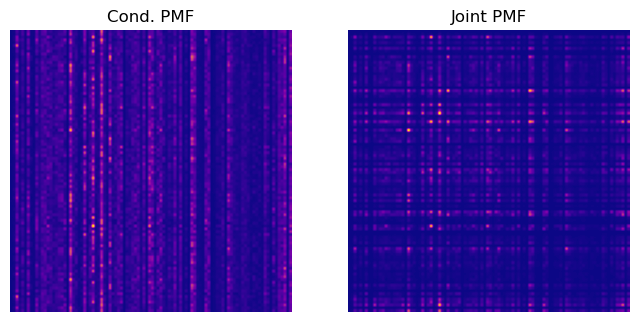

In [6]:
# Generate low-rank matrix model for given number of trials

mcs = []
P_tru = []; Q_tru = []; P_1D_tru = []; Q_1D_tru = []
for t in range(num_trials):
    mc = generate_lowrankmatrix_model(Ntot,K) # Generate low-rank matrix model
    # mc = generate_lowranktensor_model(N,K) # Generate low-rank tensor model
    mcs.append(mc)

    P_tru.append(mc.P.reshape(tuple(N.repeat(2))))
    Q_tru.append(mc.Q.reshape(tuple(N.repeat(2))))
    P_1D_tru.append(mc.P.clone())
    Q_1D_tru.append(mc.Q.clone())

fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(mc.P,'plasma'); ax[1].imshow(mc.Q,'plasma')
ax[0].set_title('Cond. PMF'); ax[1].set_title('Joint PMF')


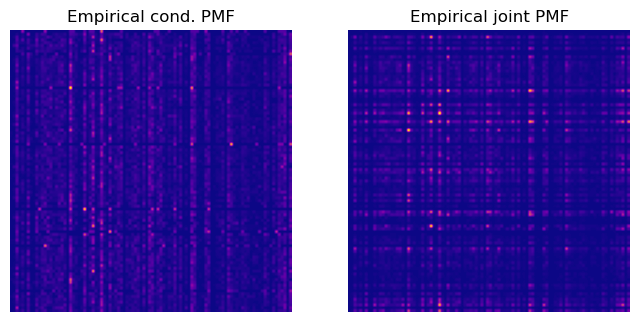

In [7]:
# Generate observed trajectories

T_range = np.logspace(3,5,5).astype(int)
burn_in = 100
Xtot = [mcs[t].simulate(T_range[-1]+burn_in)[burn_in:] for _ in range(num_trials)] # Generate full length trajectory

P_1D_obs = [[] for _ in range(num_trials)]
Q_1D_obs = [[] for _ in range(num_trials)]
P_obs = [[] for _ in range(num_trials)]
Q_obs = [[] for _ in range(num_trials)]
for t in range(num_trials):
    for T in T_range:
        Ph_1D,Qh_1D = estimate_empirical_matrix(Xtot[t][:T],Ntot)
        Ph = Ph_1D.reshape(tuple(N.repeat(2))); Qh = Qh_1D.reshape(tuple(N.repeat(2)))
        P_1D_obs[t].append(Ph_1D); Q_1D_obs[t].append(Qh_1D); P_obs[t].append(Ph); Q_obs[t].append(Qh)

fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(Ph_1D,'plasma'); ax[1].imshow(Qh_1D,'plasma')
ax[0].set_title('Empirical cond. PMF'); ax[1].set_title('Empirical joint PMF')

err_obs_P = torch.tensor([[frob_err(P_1D_obs[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_obs_Q = torch.tensor([[frob_err(Q_1D_obs[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])


100%|██████████| 5000/5000 [00:22<00:00, 226.04it/s]


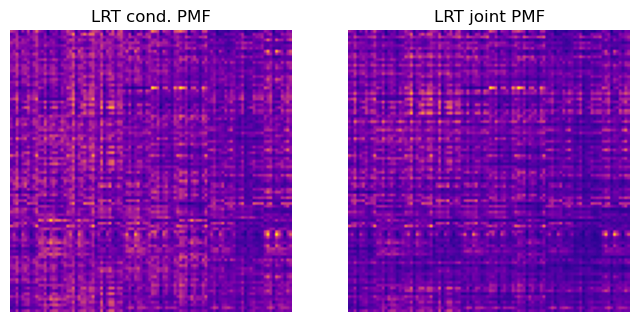

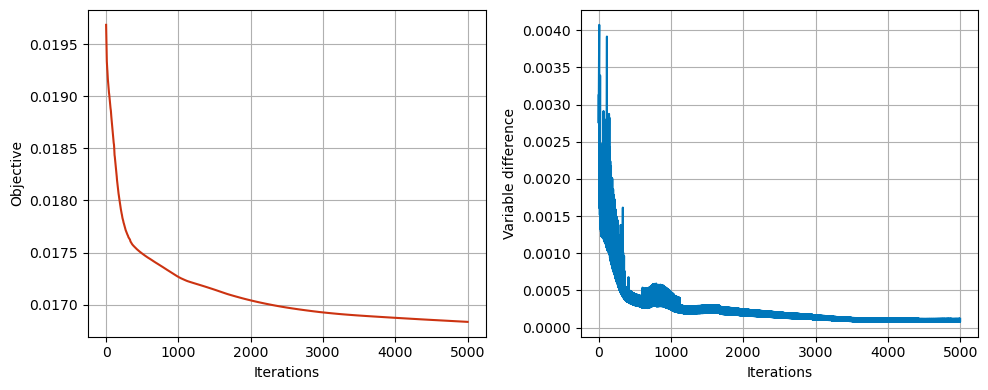

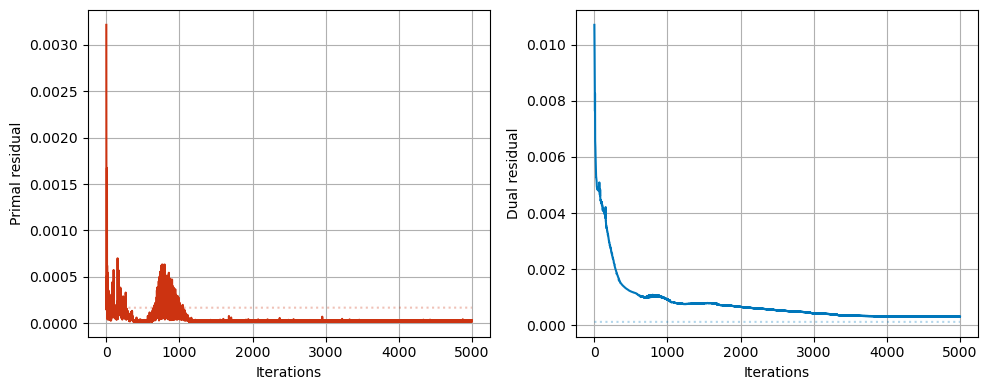

In [8]:
# Low-rank tensor estimation

lrte_est_parallel = lambda lrte,Qh,lrt_args: lrte.estimate(Qh,lrt_args)

lrt_args = {
    'K':None,
    'beta':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'max_itr':None,
    'verbose':verbose,
    'MARG_CONST':True,
    'ACCEL':True
}

lrte = [[LowRankTensorEstimator() for _ in range(len(T_range))] for _ in range(num_trials)]
lrt_args['K'] = 50
lrt_args['beta'] = .01
lrt_args['max_itr'] = 5000
results = Parallel(n_jobs=num_cpus)(delayed(lrte_est_parallel)( lrte[t][i],Q_obs[t][i],lrt_args ) for t in range(num_trials) for i in range(len(T_range)))

c = 0
P_1D_lrt = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
Q_1D_lrt = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
res_lrt = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(len(T_range)):
        P_1D_lrt[t][i] = results[c][0].P_1D
        Q_1D_lrt[t][i] = results[c][0].Q_1D
        res_lrt[t][i] = results[c][1]
        c+=1

t = 0; i = -1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(P_1D_lrt[t][i],'plasma'); ax[1].imshow(Q_1D_lrt[t][i],'plasma')
ax[0].set_title('LRT cond. PMF'); ax[1].set_title('LRT joint PMF')

err_lrt_P = torch.tensor([[frob_err(P_1D_lrt[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_lrt_Q = torch.tensor([[frob_err(Q_1D_lrt[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])

t = 0; i = 4
fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_lrt[t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_lrt[t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()

fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_lrt[t][i]['admm_res'][0],'-',c=vib_qual['red'])
ax[0].plot(res_lrt[t][i]['admm_res'][2],':',c=vib_qual['red'],alpha=.3)
ax[1].plot(res_lrt[t][i]['admm_res'][1],'-',c=vib_qual['blue'])
ax[1].plot(res_lrt[t][i]['admm_res'][3],':',c=vib_qual['blue'],alpha=.3)
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Primal residual'); ax[1].set_ylabel('Dual residual')
fig.tight_layout()


100%|██████████| 5000/5000 [00:08<00:00, 556.83it/s]


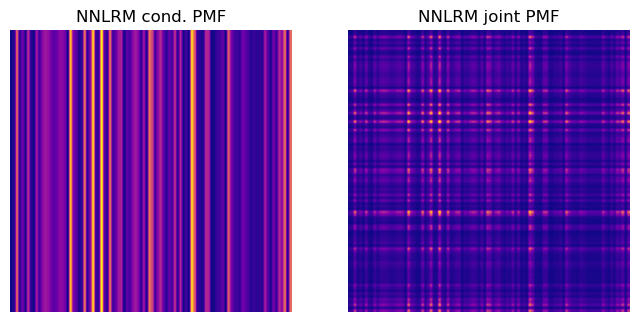

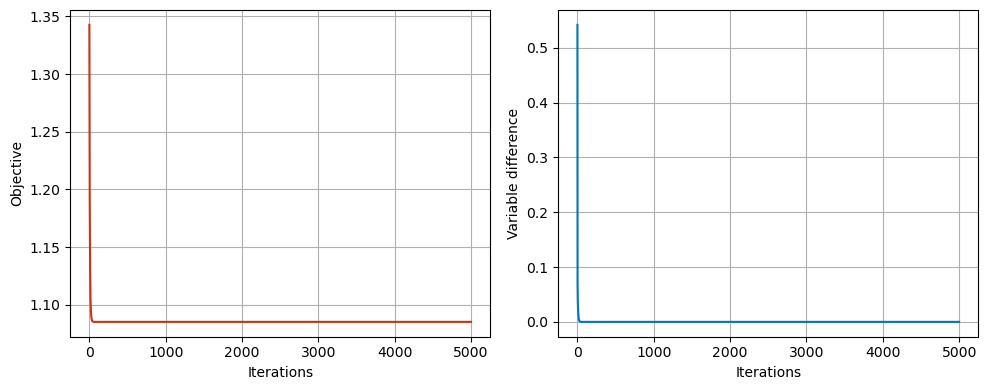

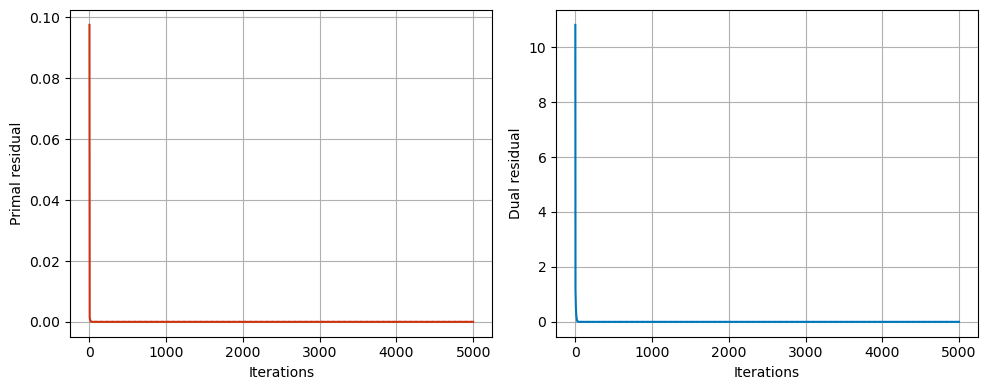

In [62]:
# Nuclear norm matrix estimation

nnlrme_est_parallel = lambda nnlrm,Ph,args: nnlrm.estimate(Ph,args)

nnlrm_args = {
    'beta':None,
    'gamma':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'max_itr':None,
    'verbose':False
}

nnlrme = [[NucNormMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)]
nnlrm_args['beta'] = 10
nnlrm_args['gamma'] = .8
nnlrm_args['max_itr'] = 5000
results = Parallel(n_jobs=num_cpus)(delayed(nnlrme_est_parallel)( nnlrme[t][i],P_1D_obs[t][i],nnlrm_args ) for t in range(num_trials) for i in range(len(T_range)))

c = 0
P_1D_nnlrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
Q_1D_nnlrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
res_nnlrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(len(T_range)):
        P_1D_nnlrm[t][i] = results[c][0].P
        Q_1D_nnlrm[t][i] = results[c][0].Q
        res_nnlrm[t][i] = results[c][1]
        c+=1

t = 0; i = -1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(P_1D_nnlrm[t][i],'plasma'); ax[1].imshow(Q_1D_nnlrm[t][i],'plasma')
ax[0].set_title('NNLRM cond. PMF'); ax[1].set_title('NNLRM joint PMF')

err_nnlrm_P = torch.tensor([[frob_err(P_1D_nnlrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_nnlrm_Q = torch.tensor([[frob_err(Q_1D_nnlrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])

t = 0; i = -1
fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_nnlrm[t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_nnlrm[t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()

fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_nnlrm[t][i]['admm_res'][0],'-',c=vib_qual['red'])
ax[0].plot(res_nnlrm[t][i]['admm_res'][2],':',c=vib_qual['red'],alpha=.3)
ax[1].plot(res_nnlrm[t][i]['admm_res'][1],'-',c=vib_qual['blue'])
ax[1].plot(res_nnlrm[t][i]['admm_res'][3],':',c=vib_qual['blue'],alpha=.3)
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Primal residual'); ax[1].set_ylabel('Dual residual')
fig.tight_layout()


100%|██████████| 500/500 [00:01<00:00, 272.23it/s]


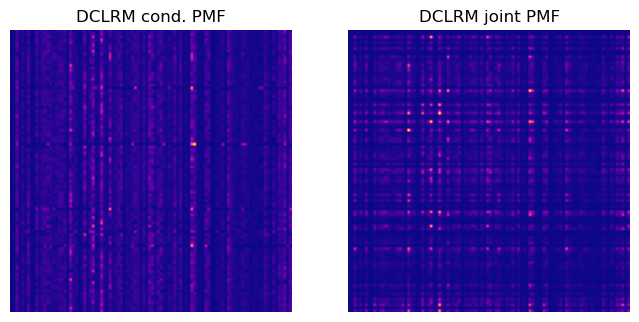

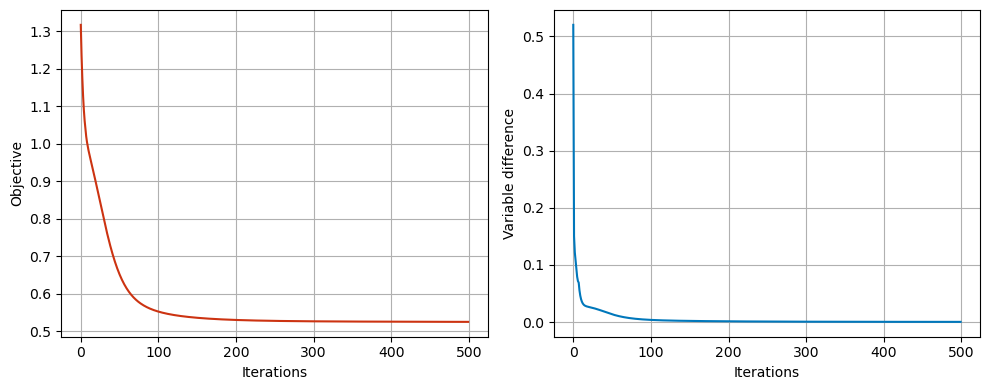

In [26]:
# Low-rank matrix estimation via DC algorithm

dclrme_est_parallel = lambda dclrm,Ph,args: dclrm.estimate(Ph,args)

dclrm_args = {
    'K':None,
    'c':None,
    'alpha':None,
    'beta':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'max_itr':None,
    'admm_itr':1,
    'verbose':False
}

dclrme = [[DCLowRankMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)]
dclrm_args['K'] = 10
dclrm_args['c'] = 5
dclrm_args['alpha'] = .5
dclrm_args['beta'] = 1
dclrm_args['max_itr'] = 500
dclrm_args['admm_itr'] = 1
results = Parallel(n_jobs=num_cpus)(delayed(dclrme_est_parallel)( dclrme[t][i],P_1D_obs[t][i],dclrm_args ) for t in range(num_trials) for i in range(len(T_range)))

c = 0
P_1D_dclrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
Q_1D_dclrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
res_dclrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(len(T_range)):
        P_1D_dclrm[t][i] = results[c][0].P
        Q_1D_dclrm[t][i] = results[c][0].Q
        res_dclrm[t][i] = results[c][1]
        c+=1

t = 0; i = -1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(P_1D_dclrm[t][i],'plasma'); ax[1].imshow(Q_1D_dclrm[t][i],'plasma')
ax[0].set_title('DCLRM cond. PMF'); ax[1].set_title('DCLRM joint PMF')

err_dclrm_P = torch.tensor([[frob_err(P_1D_dclrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_dclrm_Q = torch.tensor([[frob_err(Q_1D_dclrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])

t = 0; i = -1
fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_dclrm[t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_dclrm[t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()


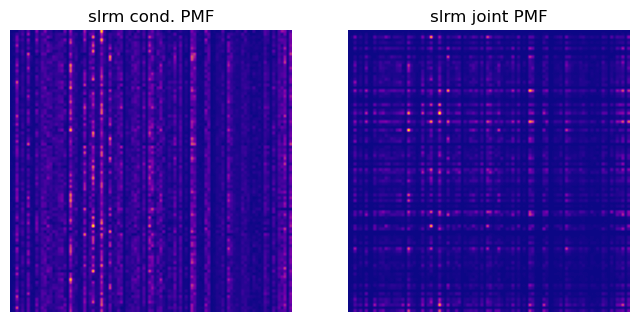

In [32]:
# Spectral low-rank matrix estimation

slrme_est_parallel = lambda slrm,Qh,K: slrm.estimate(Qh,K)

slrme = [[SpecLowRankMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)]
K_slrme = 10
# results = [[slrme[t][i].estimate(Q_1D_obs[t][i],K_slrme) for i in range(len(T_range))] for t in range(num_trials)]
results = Parallel(n_jobs=num_cpus)(delayed(slrme_est_parallel)( slrme[t][i],Q_1D_obs[t][i],K_slrme ) for t in range(num_trials) for i in range(len(T_range)))

c = 0
P_1D_slrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
Q_1D_slrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
res_slrm = [[None for _ in range(len(T_range))] for _ in range(num_trials)]
for t in range(num_trials):
    for i in range(len(T_range)):
        P_1D_slrm[t][i] = results[c][0].P
        Q_1D_slrm[t][i] = results[c][0].Q
        res_slrm[t][i] = results[c][1]
        c+=1

i = -1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
ax[0].imshow(P_1D_slrm[t][i],'plasma'); ax[1].imshow(Q_1D_slrm[t][i],'plasma')
ax[0].set_title('slrm cond. PMF'); ax[1].set_title('slrm joint PMF')

err_slrm_P = torch.tensor([[frob_err(P_1D_slrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_slrm_Q = torch.tensor([[frob_err(Q_1D_slrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])


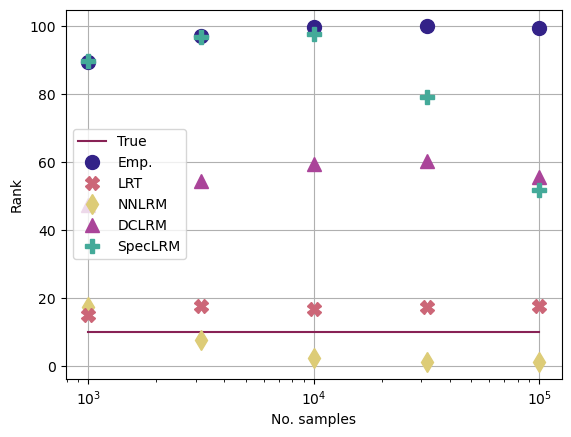

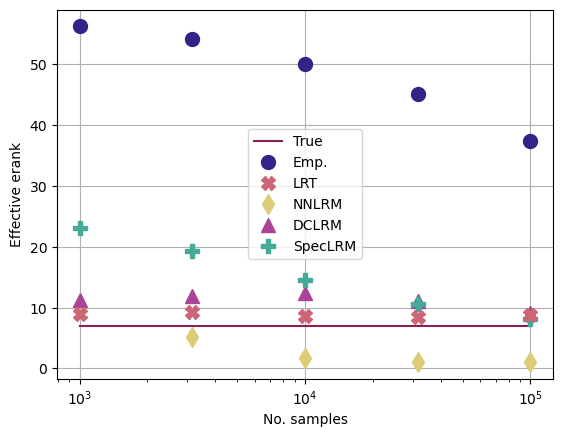

In [63]:
# Computing the rank of conditional PMFs

rank_obs = torch.tensor([[torch.linalg.matrix_rank(P_1D_obs[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_lrt = torch.tensor([[torch.linalg.matrix_rank(P_1D_lrt[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_nnlrm = torch.tensor([[torch.linalg.matrix_rank(P_1D_nnlrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_dclrm = torch.tensor([[torch.linalg.matrix_rank(P_1D_dclrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_slrm = torch.tensor([[torch.linalg.matrix_rank(P_1D_slrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)

erank_obs = torch.tensor([[erank(P_1D_obs[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_lrt = torch.tensor([[erank(P_1D_lrt[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_nnlrm = torch.tensor([[erank(P_1D_nnlrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_dclrm = torch.tensor([[erank(P_1D_dclrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_slrm = torch.tensor([[erank(P_1D_slrm[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)

erank_tru = torch.tensor([erank(P_1D_tru[t]) for t in range(num_trials)]).to(torch.float)
rank_tru = torch.tensor([torch.linalg.matrix_rank(P_1D_tru[t]) for t in range(num_trials)]).to(torch.float)

# Plot rank
clr_list = [muted_qual['indigo'],muted_qual['rose'],muted_qual['sand'],muted_qual['purple'],muted_qual['teal'],muted_qual['wine']]
methods = ['Emp.','LRT','NNLRM','DCLRM','SpecLRM','True']
mkr_list = ['o','X','d','^','P','s']

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, [rank_tru.mean(0)]*len(T_range), '-', c=clr_list[-1], label=methods[-1], markersize=10, zorder = 3 )
ax.semilogx( T_range, rank_obs.mean(0), mkr_list[0], c=clr_list[0], label=methods[0], markersize=10, zorder = 4 )
ax.semilogx( T_range, rank_lrt.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, rank_nnlrm.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, rank_dclrm.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, rank_slrm.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Rank'); ax.legend()

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, [erank_tru.mean(0)]*len(T_range), '-', c=clr_list[-1], label=methods[-1], markersize=10, zorder = 3 )
ax.semilogx( T_range, erank_obs.mean(0), mkr_list[0], c=clr_list[0], label=methods[0], markersize=10, zorder = 4 )
ax.semilogx( T_range, erank_lrt.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, erank_nnlrm.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, erank_dclrm.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, erank_slrm.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Effective erank'); ax.legend()

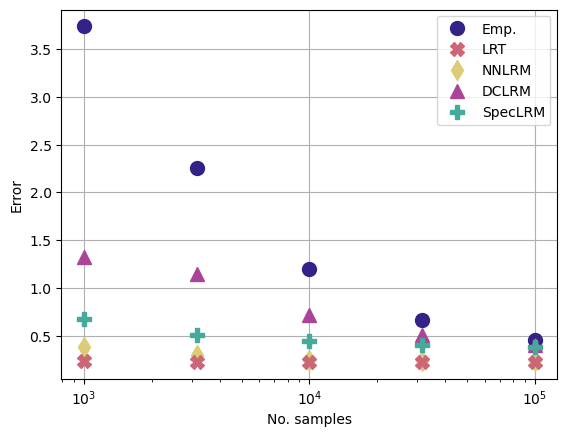

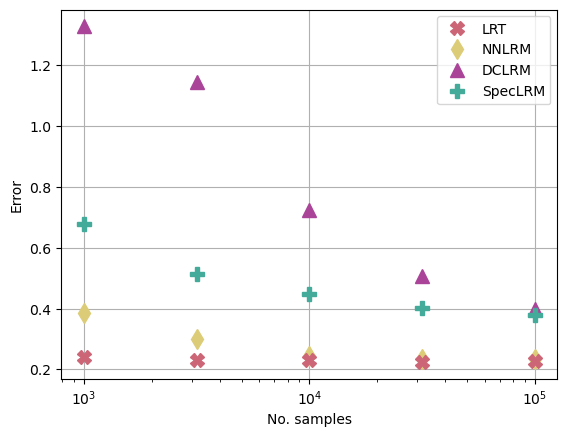

In [64]:
# Compute error of conditional PMFs

err_obs_P = torch.tensor([[normfrob_err(P_1D_obs[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_obs_Q = torch.tensor([[normfrob_err(Q_1D_obs[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_lrt_P = torch.tensor([[normfrob_err(P_1D_lrt[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_lrt_Q = torch.tensor([[normfrob_err(Q_1D_lrt[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_nnlrm_P = torch.tensor([[normfrob_err(P_1D_nnlrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_nnlrm_Q = torch.tensor([[normfrob_err(Q_1D_nnlrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_dclrm_P = torch.tensor([[normfrob_err(P_1D_dclrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_dclrm_Q = torch.tensor([[normfrob_err(Q_1D_dclrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_slrm_P = torch.tensor([[normfrob_err(P_1D_slrm[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])
err_slrm_Q = torch.tensor([[normfrob_err(Q_1D_slrm[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)])

# Plot error
clr_list = [muted_qual['indigo'],muted_qual['rose'],muted_qual['sand'],muted_qual['purple'],muted_qual['teal'],muted_qual['wine']]
methods = ['Emp.','LRT','NNLRM','DCLRM','SpecLRM','True']
mkr_list = ['o','X','d','^','P','s']

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, err_obs_P.mean(0), mkr_list[0], c=clr_list[0], label=methods[0], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_lrt_P.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, err_nnlrm_P.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_dclrm_P.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_slrm_P.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Error'); ax.legend()

fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, err_lrt_P.mean(0), mkr_list[1], c=clr_list[1], label=methods[1], markersize=10, zorder = 5 )
ax.semilogx( T_range, err_nnlrm_P.mean(0), mkr_list[2], c=clr_list[2], label=methods[2], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_dclrm_P.mean(0), mkr_list[3], c=clr_list[3], label=methods[3], markersize=10, zorder = 4 )
ax.semilogx( T_range, err_slrm_P.mean(0), mkr_list[4], c=clr_list[4], label=methods[4], markersize=10, zorder = 4 )
ax.set_xlabel('No. samples'); ax.set_ylabel('Error'); ax.legend()